In [22]:
from collections import OrderedDict, namedtuple
from typing import List
from functools import reduce

class StockTradeDays(object): 
    
    def __init__(self, 
                 price_array: List[int], 
                 start_date: str, 
                 date_array: List[int] = None):
        # Private Price Array
        self.__price_array = price_array
        # Private Date Array
        self.__date_array = self._init_days(start_date, date_array)
        # Private Change Array
        self.__change_array = self.__init_change()
        # Construct OrderedDict
        self.stock_dict = self._init_stock_dict()
    
    def __init_change(self):
        """
        Generate change_array from price_array
        :return: 
        """
        price_float_array = [float(price_str) for price_str in self.__price_array]
        
        # Move the price to generate a change_array
        pp_array = [(price1, price2) for price1, price2 in zip(price_float_array[:-1], price_float_array[1:])]
        change_map = map(
            lambda pp: reduce(
                lambda  a, b: round(
                    (b - a) / a, 
                    3), 
                pp),
            pp_array)
        
        # list insert() function insert first date change as 9.
        change_array = list(change_map)
        change_array.insert(0, 0)
        return change_array
    
    def _init_days(self, 
                   start_date:str, 
                   date_array:List[int]):
        """
        protected function,
        :param start_date: First date
        :param date_array: date_array
        :return:
        """
        if date_array is None:
            # Use start_date and self.__price_arary to determine date_array
            date_array = [str(start_date + index) for index, _ in enumerate(self.__price_array)]
        else:
            # Use date_array if provided
            date_array = [str(date) for date in date_array]
        return date_array
    
    def _init_stock_dict(self):
        """
        Use namedtupple, OrderedDict to combine results
        :return: 
        """
        stock_namedtuple = namedtuple('stock', 
                                      ('date', 'price', 'change'))
        # Use defined __date_array to combine OrderedDict
        stock_dict = OrderedDict(
            (date, stock_namedtuple(date, price, change))
            for date, price, change in
            zip (self.__date_array, self.__price_array, self.__change_array))
        return stock_dict
    
    def filter_stock(self, 
                     up_days_only: bool = True, 
                     want_calc_sum: bool = False):
        """
        Filter stock result
        :param up_days_only: 
        :param want_calc_sum: 
        :return: 
        """
        # Use filter_func as Filter
        filter_func = (lambda day: day.change > 0) if up_days_only \
            else (lambda day: day.change < 0)
        
        filtered_days = list(filter(filter_func, self.stock_dict.values()))
        
        if not want_calc_sum:
            return filtered_days
        
        # Need to calculate the sum
        change_sum = 0.0
        for day in filtered_days:
            change_sum += day.change
            return change_sum
        
    def __str__(self):
        return str(self.stock_dict)
    
    __repr__ = __str__
        
    def __iter__(self):
        """
        Iterate stock_dict to yield elements
        :return: 
        """
        for key in self.stock_dict:
            yield self.stock_dict[key]
        
    def __getitem__(self, index):
        date_key = self.__date_array[index]
        return self.stock_dict[date_key]
    
    def __len__(self):
        return len(self.stock_dict)
    

In [23]:
import six
from abc import ABCMeta, abstractmethod

class TradeStrategyBase(six.with_metaclass(ABCMeta, object)):
    """
    Trading Strategy Abstract Base Class
    """
    @abstractmethod
    def buy_strategy(self, *args, **kwargs):
        # Base Buy Strategy 
        pass
    
    @abstractmethod
    def sell_strategy(self, *args, **kwargs):
        # Base Sell Strategy
        pass

In [31]:
class TradeStrategy1(TradeStrategyBase):
    """
    Trade Strategy 1: Follow the upward trend.
    When price rise above an absolute threshold, set to 2%, buy and hold s_keep_stock_threshold (20) days. 
    """
    s_keep_stock_threshold = 20
    
    def __init__(self):
        self.held_period_days = 0
        # Buy threshold 2%
        self.__buy_change_threshold = 0.02
        
    def buy_strategy(self, trade_index, trade_day, trade_days):
        if self.held_period_days == 0 and \
                trade_day.change > self.__buy_change_threshold:
            # When there is no holding, and situation meets the above threshold
            self.held_period_days += 1
        elif self.held_period_days > 0:
            # self.held_period_days > 0, means already holding, increment held_period_days by 1
            self.held_period_days += 1

    def sell_strategy(self, trade_index, trade_day, trade_days):
        if self.held_period_days >= \
            TradeStrategy1.s_keep_stock_threshold:
            # When holding period exceeds s_keep_stock_threshold, sell stocks
            self.held_period_days = 0
    
    @property
    def buy_change_threshold(self):
        return self.__buy_change_threshold
    
    @buy_change_threshold.setter
    def buy_change_threshold(self, buy_change_threshold):
        if not isinstance(buy_change_threshold, float):
            """
                Upward threshold needs to be a float type.
            """
            raise TypeError('buy_change_threshold must be float!')
        # Take only the last 2 digits in Upward threshold
        self.__buy_change_threshold = round(buy_change_threshold, 2)

In [73]:
class TradeLoopBack(object):
    """
    Trade Back-Testing System
    """
    def __init__(self, trade_days, trade_strategy):
        """
        Initialize trading system using StockTradeDays and TradeStrategyBase
        :param trade_days: StockTradeDays 
        :param trade_strategy: TradeStrategyBase
        """
        self.trade_days = trade_days
        self.trade_strategy = trade_strategy
        # Profit Array from Trading
        self.profit_array = []
        
    def execute_trade(self):
        """
        Executing the back-test
        :return: 
        """ 
        for index, day in enumerate(self.trade_days):
            """
            Iterate through dates, execute the back-test
            """
            if self.trade_strategy.held_period_days > 0:
                # If holding, add trading profit
                self.profit_array.append(day.change)
            # hasattr: To check if a attribute exists
            if hasattr(self.trade_strategy, 'buy_strategy'):
                # Execute Buy
                self.trade_strategy.buy_strategy(index, day, self.trade_days)
                
            if hasattr(self.trade_strategy, 'sell_strategy'):
                # Execute Sell
                self.trade_strategy.sell_strategy(index, day, self.trade_days)
            

In [47]:
from abupy import ABuSymbolPd, EMarketDataSplitMode
# List 2 years of MasterCard closing price to list()
price_array = ABuSymbolPd.make_kl_df('MA', EMarketDataSplitMode.E_DATA_SPLIT_SE).close.tolist()
date_array = ABuSymbolPd.make_kl_df('MA', EMarketDataSplitMode.E_DATA_SPLIT_SE).date.tolist()
price_array[:], date_array[:]

([121.65,
  122.88,
  123.4,
  125.2,
  125.9,
  125.24,
  125.19,
  124.76,
  123.04,
  120.76,
  122.32,
  122.5,
  121.42,
  121.96,
  123.09,
  122.93,
  123.1,
  123.4,
  124.01,
  123.52,
  122.74,
  124.81,
  121.51,
  121.45,
  120.78,
  121.98,
  120.8,
  122.2,
  122.73,
  124.23,
  125.28,
  125.47,
  127.01,
  127.43,
  127.73,
  128.04,
  128.47,
  129.27,
  129.52,
  129.98,
  130.99,
  128.93,
  127.91,
  127.8,
  129.49,
  130.61,
  129.89,
  129.82,
  130.38,
  129.84,
  129.72,
  127.67,
  128.55,
  131.09,
  131.58,
  132.37,
  130.88,
  131.14,
  131.94,
  133.8,
  133.07,
  132.96,
  132.75,
  133.85,
  133.84,
  133.8,
  133.3,
  133.24,
  132.66,
  132.89,
  136.53,
  137.22,
  141.98,
  142.4,
  140.1,
  141.51,
  141.58,
  141.54,
  142.66,
  142.24,
  141.75,
  141.89,
  138.57,
  138.35,
  139.69,
  140.14,
  141.17,
  142.01,
  143.01,
  142.13,
  143.74,
  143.49,
  144.53,
  145.58,
  146.815,
  146.66,
  147.35,
  146.19,
  145.85,
  146.19,
  144.945,
  

In [48]:
# Create Trade Days
trade_days = StockTradeDays(price_array, "", date_array)
print('trade_days has {} days'.format(len(trade_days)))
print('Last trading day: {}'.format(trade_days[-1]))

trade_days has 401 days
Last trading day: stock(date='20181231', price=186.43, change=0.0)


In [75]:
# Back Test Strategy
trade_loop_back = TradeLoopBack(trade_days, TradeStrategy1())
trade_loop_back.execute_trade()
print('TradeStrategy1 Total Profit: {}%'.format(
    reduce(lambda a, b: a + b, trade_loop_back.profit_array) * 100
))

TradeStrategy1 Total Profit: 6.5000000000000115%


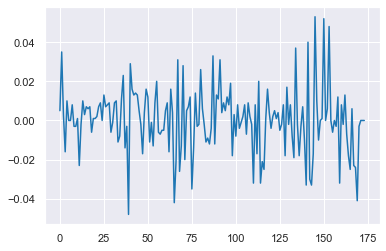

In [79]:
# Visulazation
import numpy as np
from matplotlib import pyplot
pyplot.plot(np.array(trade_loop_back.profit_array))